# Transfer Learning using EfficientNetB5

# Explanation on model
## Introduction
The task of our assignment is to build an Image Classifier for photos that have been captured by SMU Undergraduates and Graduate students.  The images are from a total of 72 classes, and have already been pre-arranged into sub-folders where each of the folder names will be the label that is used.

This submission uses the [EfficientNetB5 algorithm](https://ai.googleblog.com/2019/05/efficientnet-improving-accuracy-and.html), which manages to achieve superior performance vs competing algorithms with lesser parameters (see diagram below).  This speeds up training time significantly while allowing researchers to try different model prototypes.

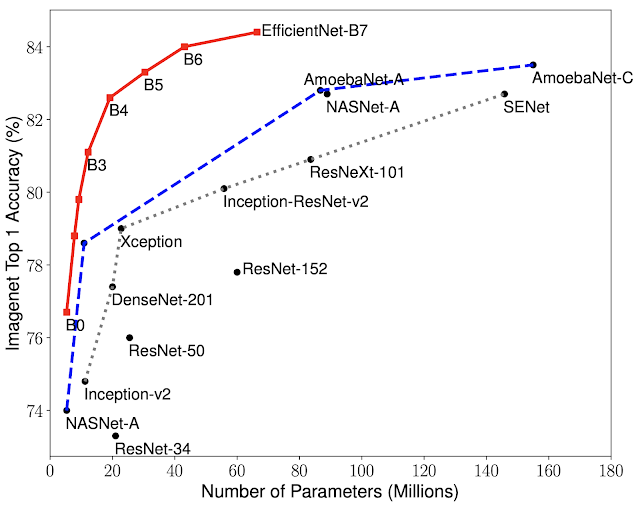

## Data Used
The data provided as part of this assignment had been split up into 72 subfolders, with the name of the subfolder as the class name.  Prior to the start of the training, we had performed the following data preparation as it aided in the flow and also sped up the training else the bottleneck becomes the CPU-intensive task of resizing the full-sized pictures into 456x456 images.  In earlier runs, the CPU could not feed the images fast enough to the GPU for training, and each repeated run went through the same unncessary process of resizing again.

Thus, we had performed the following:

1. Create a train-val-test subfolder structure using the splitfolders Python package.  The package can be downloaded from the [PyPi repository](https://pypi.org/project/split-folders/)
2. Ran the helper script to resize the images in these folders to the desired size.  In the setup, we had created a few sets of image sizes as we wanted to experiment with different EfficientNetB* algorithms, each requiring different image sizes as highlighted below:

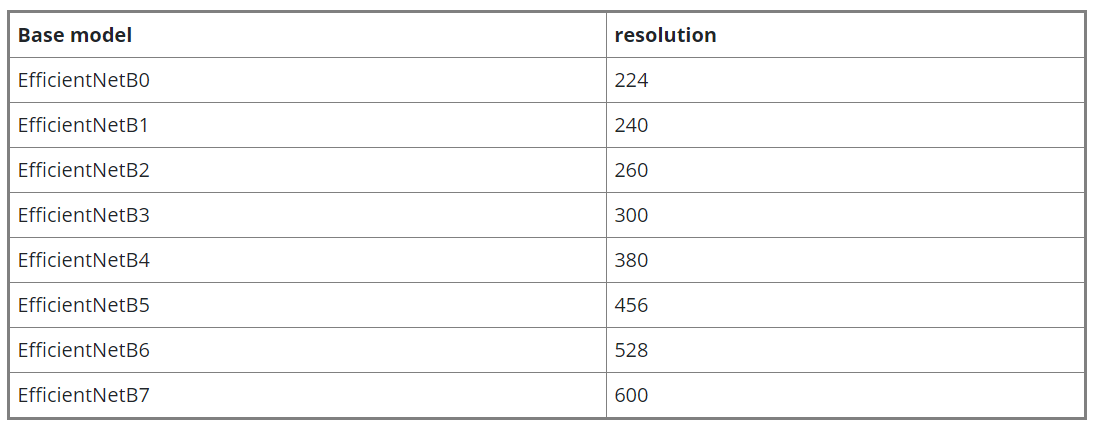

## Training Phases
We perform the training in two distinct steps.

### Phase 1 - Using pre-trained weights to arrive at a quick model
We create the initial model from the EfficientNetB5 model, with <code>include_top=False</code>.  We will rebuild our own "top" layer which comprises the GlobalAveragePooling, Dropout (20%), and connected to a final (NUM_CLASS,) Dense layer to perform a softmax computation.  

We freeze the original model with the exception of the final layer as we will then use this to quickly learn the weights based on the pre-trained model (pre-trained on ImageNet).

In this phase, we run 50 epochs and the learning rate can be fairly high at 1e-02.

### Phase 2 - Unfreeze Block7a onwards and perform fine-tune training
After we have arrived at a rough model, we then unfreeze Block 7 of the EfficientNetB5.  Because of the skip connections, we must ensure that we unfreeze the **ENTIRE** block, and also to freeze back any BatchNormalization layers.  This is achieved in the unfreeze_model() code in this notebook.

We then **CONTINUE** running the training with a reduced learning rate of 1e-04 for another 50 epochs.  You can see from the accuracy history charts that after a period of plateued performance in Phase 1, the accuracy increases again with this refined phase.

## 


The concepts here are inspired by the official [Tensorflow tutorials](https://www.tensorflow.org/tutorials/images/transfer_learning) on using Transfer Learning to adapt models quickly.

https://www.tensorflow.org/tutorials/images/transfer_learning


In [1]:
!nvidia-smi

Wed Apr 14 09:32:03 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 460.39       CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 3090    Off  | 00000000:01:00.0 Off |                  N/A |
| 39%   50C    P0    57W / 350W |    575MiB / 24265MiB |    100%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  GeForce RTX 3090    Off  | 00000000:21:00.0 Off |                  N/A |
| 31%   

In [2]:
import os
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = "0,1" #please put your GPU

# Import necessary libraries

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import layers
from tensorflow.keras.applications import EfficientNetB5

In [4]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)
        
# Set the TF deployment strategy - training on all visible GPUs in parallel
strategy = tf.distribute.MirroredStrategy()

2 Physical GPUs, 2 Logical GPUs
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


In [6]:
# Training image dimensions
IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS = (456, 456, 3) # EfficientNetB5 uses (456,456,3)
IMG_DIMS = (IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS)

# Define components of the save file
AUTHOR = 'GerryChng'
MODEL = 'EfficientNetB5'
VERSION = '20210414_01'

DATA_ROOT_FOLDER = os.path.join('..', '..', 'data_presplit')


# Define folders to the images for training, validation, and test
DATA_FOLDER = os.path.join(DATA_ROOT_FOLDER, "_".join(['data', str(IMG_WIDTH), 'split']))


IMAGE_TRAIN_FOLDER = os.path.join(DATA_FOLDER, 'train')
IMAGE_VAL_FOLDER = os.path.join(DATA_FOLDER, 'val')
IMAGE_TEST_FOLDER = os.path.join(DATA_FOLDER, 'test')

IMAGE_TRAIN_FOLDER, IMAGE_VAL_FOLDER, IMAGE_TEST_FOLDER

('../../data_presplit/data_456_split/train',
 '../../data_presplit/data_456_split/val',
 '../../data_presplit/data_456_split/test')

In [7]:
sorted_class = np.load(os.path.join('test_fn_updated', 'sorted_classes.npy'))
CLASS_NAMES = sorted_class.tolist()

In [8]:
# Define the training dataset
train_dir = IMAGE_TRAIN_FOLDER
validation_dir = IMAGE_VAL_FOLDER
test_dir = IMAGE_TEST_FOLDER

BATCH_SIZE = 128
IMG_SIZE = (IMG_WIDTH, IMG_HEIGHT)

train_dataset = image_dataset_from_directory(train_dir,
                                             label_mode='categorical',
                                             class_names=CLASS_NAMES,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

validation_dataset = image_dataset_from_directory(validation_dir,
                                                  label_mode='categorical',
                                                  class_names=CLASS_NAMES,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE)

test_dataset = image_dataset_from_directory(test_dir,
                                            label_mode='categorical',
                                            class_names=CLASS_NAMES,
                                            shuffle=True,
                                            batch_size=BATCH_SIZE,
                                            image_size=IMG_SIZE)

Found 21195 files belonging to 72 classes.
Found 4518 files belonging to 72 classes.
Found 4601 files belonging to 72 classes.


In [9]:
# Show some of the sampled pictures
class_names = train_dataset.class_names
num_classes = len(class_names)

plt.figure(figsize=(20,20))
for images, labels in train_dataset.take(10):
    for i in range(32):
        ax = plt.subplot(8, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[np.argmax(labels[i])])
        plt.axis("off")

# Configure the dataset for performance

Use buffered prefetching to load images from disk without having I/O become blocking. To learn more about this method see the <a href=https://www.tensorflow.org/guide/data_performance>data performance guide</a>.

In [10]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

# Use data augmentation
Create data augmentation using random horizontal flips and random rotations within 20degs

In [11]:
from tensorflow.keras.layers.experimental import preprocessing

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
], name='data_augmentation')

### Let's do a check of the randomness that the data_augmentation function does

In [12]:
for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

# Phase 1 - Build the base model

Here, we will load in the EfficientNetB5 model with the layers frozen, and rebuild the top.  We will only train the top layers based on the existing pre-trained weights done on ImageNet.

In [15]:
#
# DEFINE YOUR PREPROCESS HERE DEPENDING ON THE MODEL YOU ARE USING
#
preprocess_input = tf.keras.applications.efficientnet.preprocess_input

def build_model(num_classes):
    
    inputs = layers.Input(shape=(IMG_WIDTH, IMG_HEIGHT, 3))
    x = preprocess_input(inputs)
    x = data_augmentation(x)
    
    # Create the base model from the pre-trained model EfficientNetB5
    IMG_SHAPE = IMG_SIZE + (3,)
    base_model = tf.keras.applications.EfficientNetB5(input_shape=IMG_SHAPE,
                                                      input_tensor=x,
                                                      include_top=False,
                                                      weights='imagenet')
    # Freeze the pretrained weights
    base_model.trainable = False

    # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(base_model.output)
    x = layers.BatchNormalization()(x)

    top_dropout_rate = 0.2
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(num_classes, activation="softmax", name="pred")(x)

    # Compile
    model = tf.keras.Model(inputs, outputs, name="EfficientNet")
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )
    return model

In [16]:
with strategy.scope():
    model = build_model(num_classes=num_classes)
model.summary()

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Redu

# Let's train and evaluate the model.

Before we begin, let's run the UNTRAINED model on the validation set.  Since there are 72 classes, a random guess should only be as good as roughly 1.4% accuracy.

In [18]:
with strategy.scope():
    loss0, accuracy0 = model.evaluate(validation_dataset)
    print("initial loss: {:.2f}".format(loss0))
    print("initial accuracy: {:.1f}%".format(accuracy0 * 100))

36/36 [==============================] - 31s 463ms/step - loss: 4.2931 - accuracy: 0.0119
initial loss: 4.30
initial accuracy: 1.2%


In [19]:
initial_epochs = 50

filepath = '_'.join([AUTHOR, MODEL, VERSION, 'initial.h5'])
checkpoint = ModelCheckpoint(filepath=filepath, mode='max', monitor='val_accuracy', verbose=1, save_best_only=True)
callbacks_list = [checkpoint]

tf.debugging.set_log_device_placement(True)
with strategy.scope():
    history = model.fit(train_dataset,
                        epochs=initial_epochs,
                        validation_data=validation_dataset,
                        callbacks=callbacks_list)

Epoch 1/50
INFO:tensorflow:batch_all_reduce: 4 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 4 all-reduces with algorithm = nccl, num_packs = 1
166/166 [==============================] - 137s 705ms/step - loss: 1.9822 - accuracy: 0.6603 - val_loss: 0.9079 - val_accuracy: 0.7189

Epoch 00001: val_accuracy improved from -inf to 0.71890, saving model to GerryChng_EfficientNetB5_20210414_01_initial.h5
Epoch 2/50
166/166 [==============================] - 116s 686ms/step - loss: 0.9583 - accuracy: 0.7872 - val_loss: 0.6699 - val_accuracy: 0.8037

Epoch 00002: val_accuracy improved from 0.71890 to 0.80367, saving model to GerryChng_EfficientNetB5_20210414_01_initial.h5
Epoch 3/50
166/166 [==============================] - 115s 682ms/step - loss: 0.7154 - accuracy: 0.8146 - val_loss: 0.6276 - val_accuracy: 0.8320

Epoch 00003: val_accuracy improved from 0.80367 to 0.83201, saving model to GerryChng_EfficientNetB5_20210414_01_initial.h5
Epoch 4/50
166/166 [

# Model performance curves

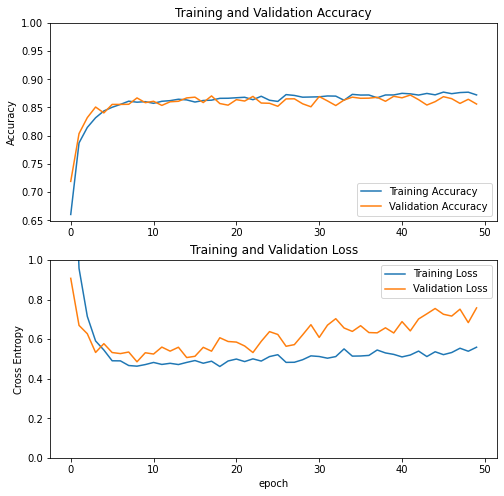

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# Phase 2 - Fine tune the model
Unfreeze the top layers

In [21]:
def unfreeze_model(model):
    # We unfreeze the top 50 layers while leaving BatchNorm layers frozen
    for layer in model.layers[-50:]:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True

    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )


unfreeze_model(model)

Lower the learning rate so that we do not digress too quickly from the pre-trained weights

# Continue the fine-tune training

In [22]:
fine_tune_epochs = 50
total_epochs =  initial_epochs + fine_tune_epochs

filepath = '_'.join([AUTHOR, MODEL, VERSION, 'finetune.h5'])
checkpoint = ModelCheckpoint(filepath=filepath, mode='max', monitor='val_accuracy', verbose=1, save_best_only=True)
callbacks_list = [checkpoint]

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset,
                         callbacks=callbacks_list)

Epoch 50/100
INFO:tensorflow:batch_all_reduce: 26 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 26 all-reduces with algorithm = nccl, num_packs = 1
166/166 [==============================] - 146s 740ms/step - loss: 0.3987 - accuracy: 0.9027 - val_loss: 0.4683 - val_accuracy: 0.8986

Epoch 00050: val_accuracy improved from -inf to 0.89863, saving model to GerryChng_EfficientNetB5_20210414_01_finetune.h5
Epoch 51/100
166/166 [==============================] - 118s 700ms/step - loss: 0.2544 - accuracy: 0.9347 - val_loss: 0.4444 - val_accuracy: 0.9104

Epoch 00051: val_accuracy improved from 0.89863 to 0.91036, saving model to GerryChng_EfficientNetB5_20210414_01_finetune.h5
Epoch 52/100
166/166 [==============================] - 114s 671ms/step - loss: 0.1707 - accuracy: 0.9502 - val_loss: 0.4581 - val_accuracy: 0.9177

Epoch 00052: val_accuracy improved from 0.91036 to 0.91766, saving model to GerryChng_EfficientNetB5_20210414_01_finetune.h5
Epoch 53/

Evaluate the improvements to the model after the fine-tuning

In [23]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

In [24]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.5, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# Evaluation and prediction

In [25]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

36/36 [==============================] - 21s 505ms/step - loss: 0.3748 - accuracy: 0.9504
Test accuracy : 0.9504455327987671


In [26]:
dataset = test_dataset
for i, element in enumerate(dataset):
    print('Batch', i)
    image_batch, label_batch = element
    predictions = model.predict_on_batch(image_batch)

    # Obtain the index where the softmax predicted the class
    predictions_idx = np.argmax(predictions, axis=1)
    label_idx = np.argmax(label_batch, axis=1)

    print('Predictions:\n', predictions_idx)
    print('Labels:\n', label_idx)

Batch 0
Predictions:
 [33 68 47 38 47 40 70 67  4 35 69 41 44 31 33 45 67 56 41 22 52 43 59 24
 69 18 23 20 33 39 19 66 17 49 49 15 39 39  4 24 65 55 67 33 44 50 51 15
 52 22 58 56 42 15 66 11 70 16 35 42 48 55 33 65 21 35 67 45 43 15 70 22
 33 70 64 50  8 52  7 35 35 70 44 21 44 21 63 20 71 58 58 42 52 52 37 19
 43  3 16 49 44 43 14 62 25 52 47 44 52 30 56 33 49 67 44 24 52 43 33 21
 70 28 36 14 49 65 64 21]
Labels:
 [33 68 47 38 47 40 70 67  4 35 69 41 44 31 33 45 67 56 41 22 52 43 59 24
 69 28 23 20 33 39 19 66 17 49 49 15 39 39  4 66 65 55 67 33 44 50 51 15
 52 22 58 56 42 15 66 11 70 16 35 42 48 55 33 65 21 35 67 45 43 15 70 22
 33 70 64 50  8 52  7 35 35 70 44 21 44 21 63 20 71 58 58 42 52 52 37 19
 43  3 16 49 44 43 14 62 25 52 47 44 52 30 56 33 49 67 44 24 52 43 33 21
 70 28 36 14 49 65 64 21]
Batch 1
Predictions:
 [15 24 22 52 21 25 44 19 58 52 13 35 71 50  7  2 49 51 14 49 13 42 42 27
 14 70 35 59 61 60 33 59 20 51 67 56  5 33 46 16 19 19 67 42 46 34 21  8
 58  7 43 18 69 46 

In [28]:
#Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)

# Obtain the index where the softmax predicted the class
predictions_idx = np.argmax(predictions, axis=1)
label_idx = np.argmax(label_batch, axis=1)

print('Predictions:\n', predictions_idx)
print('Labels:\n', label_idx)

plt.figure(figsize=(10, 40))
for i in range(64):
    ax = plt.subplot(16, 4, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    plt.title(class_names[predictions_idx[i]])
    plt.axis("off")

Predictions:
 [24 14 33 32 44 27 46 54 42 30 42 70 49 24 34 56 33 21 69 37 31 65 49  7
 59 45 52 20 36 21 32 56 50 45 16 15 42 22 47 52 49  2 45  4 35 70 17 64
 44 30 35 62 26  7 56 24 22 35 24 49 52 47 35  7 37 66 31 28 52 21 62 52
 48 13 16 12 35 64 18 62 15 18 65 33 55 42 43 68 47 42 52 67 34 50 29 21
 40 11 52 65 47 25 61 70 45 41 31 19 57 67 20 70 58 56 18 15 51 15 49 21
 63 35 35 21 52 30 27 61]
Labels:
 [24 14 33 32 40 27 46 54 42 30 42 70 49 29 34 56 33 21 69 37 31 65 49  7
 59 45 52 67 36 21 32 56 50 45 16 23 42 22 47 52 49  2 45  4 35 70 17 64
 44 30 35 62 26  7 56 24 22 35 24 49 52 47 35  7 37 66 31 28 52 21 62 52
 48 43 16 12 49 64 28 62 15 18 65 33 55 42 43 68 47 42 52 67 34 50 29 21
 40 11 52 65 47 25 61 70 45 41 31 19 57 67 20 70 58 56 18 15 51 15 49 21
 63 35 35 21 52 65 27 61]


In [29]:
model.save('_'.join([MODEL, VERSION]))

INFO:tensorflow:Assets written to: EfficientNetB5_20210414_01/assets


In [30]:
import pickle

# Define the save names
base_filepath = '_'.join([AUTHOR, MODEL, VERSION])
json_filepath = base_filepath+'.json'
weights_filepath = base_filepath+'.h5'
pkl_filepath = base_filepath+'.pkl'

# save model and weights
model_json = model.to_json()

with open(json_filepath, "w") as json_file:
    json_file.write(model_json)
model.save_weights(weights_filepath)

# save history
with open(pkl_filepath, 'wb') as history_file:
    pickle.dump(history.history, history_file)